In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapz
from scipy.stats import binned_statistic
from scipy.special import spherical_jn
import camb

%matplotlib inline

In [2]:
# for plots
import seaborn as sns
sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': '--'})
sns.set_context("poster")
sns.set_palette("Set2")

In [3]:
# cosmology
pars = camb.CAMBparams()

In [19]:
# planck 2015 TT+lowP+lensing
# https://www.aanda.org/articles/aa/full_html/2016/10/aa25830-15/aa25830-15.html
pars.set_cosmology(ombh2=0.02226, 
                   omch2=0.1186,
                   cosmomc_theta=1.04103/100,
                   H0 = None,
                   tau = 0.066)

pars.InitPower.set_params(ns=0.9677,
                          As=2.139e-9)

pars.set_matter_power(redshifts=[0])

#results
results = camb.get_results(pars)

In [20]:
# use these two lines to compare with Planck derived parameters (Table 4 of 2015 parameters
# paper)
# results.get_derived_params()
# results.get_sigma8()

In [21]:
# linear matter power spectrum
kh, z, [pk] = results.get_matter_power_spectrum(npoints=2000)

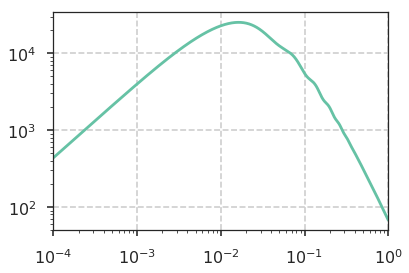

In [22]:
plt.loglog(kh, pk)
plt.xlim(kh.min(),kh.max())
plt.show()

In [23]:
# # correlation function
# def xi(r,k,pk):
#     num = k*pk*np.sin(k*r)
#     den = 2*(np.pi**2)*r
#     integral = trapz(num/den,k)
#     return integral

# correlation function
def xi(r,k,pk):
    num = k**2 * pk* spherical_jn(0,k*r)
    den = 2*(np.pi**2)
    integral = trapz(num,k)
    return integral/den

In [24]:
def xi_binned(r, xi, bin_size=3):
    """r: array of positions to evalue correlation function over"""
    bins = np.arange(r.min(),r.max()+bin_size,bin_size)
    bin_means, bin_edges = binned_statistic(r,xi,statistic='mean',bins=bins)[:2]
    bin_centers = bin_edges[1:] - bin_size/2
    return bin_centers, bin_means

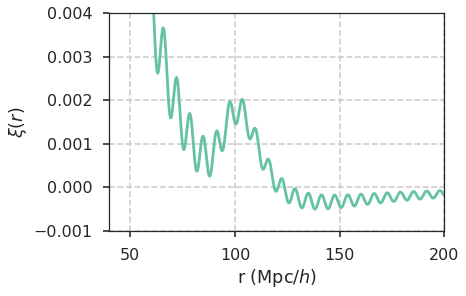

In [36]:
r = np.linspace(40,200,500)
xi_r = [xi(i, kh, pk) for i in r]

plt.plot(r, xi_r, label=r'$\xi(r)$')
#plt.plot(*xi_binned(r,xi_r), label=r'$\xi(r)$ binned')

plt.ylim(-0.001,0.004)
plt.xlim(r.min(),r.max())
#plt.legend()

plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'r (${\rm Mpc}/h$)')

plt.savefig('Figures/xi_r.png', dpi=300, bbox_inches='tight',
           facecolor='w', edgecolor='w')
plt.show()

In [11]:
# polynomial fit
class Polyfit:
    def __init__(self,order):
        self.order = order
    def do_fit(self, r, xi):
        self.coeffs = np.polyfit(r, xi, self.order)
    def get_fit(self, r):
        return np.dot(r**np.arange(self.order+1)[::-1],self.coeffs)

In [16]:
order = 7

# straight from integral
r = np.linspace(70,120,500)
xi_r = [xi(i, kh, pk) for i in r]

# fitting on integral result
pfit = Polyfit(order)
pfit.do_fit(r,xi_r)
xi_fit = [pfit.get_fit(i) for i in r]

# binning integral result
r_bin, xi_bin = xi_binned(r,xi_r)
# fitting on binned data
pfit = Polyfit(order)
pfit.do_fit(r_bin,xi_bin)
xi_fb = [pfit.get_fit(i) for i in r]

plt.plot(r, xi_r, label=r'$\xi(r)$')
plt.plot(r, xi_fit, label=r'$\xi(r)$ fit')
plt.plot(r, xi_fb, label=r'$\xi(r)$ binned fit')


plt.ylim(ymax=0.003)
plt.legend(loc='upper right')
plt.xlim(r.min(),r.max())
plt.show()

NameError: name 'Polyfit' is not defined

<h3> Why is $\xi(r)$ oscillatory like this?  </h3>

In [13]:
# let's look at the integrand

In [14]:
def xi_integrand(r, k, pk):
    num = k**2 * pk* spherical_jn(0,k*r)
    den = 2*(np.pi**2)
    return num/den

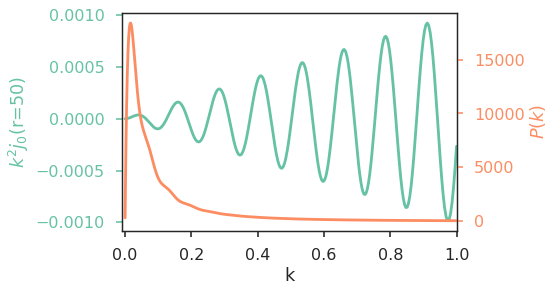

In [48]:
fig, ax1 = plt.subplots()
ax1.plot(kh, xi_integrand(50, kh, 1), 'C0-')
ax1.set_xlabel('k')
# # Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'$k^2 j_0$(r=50)', color='C0')
ax1.tick_params('y', colors='C0')

ax2 = ax1.twinx()
ax2.plot(kh, pk, 'C1')
ax2.set_ylabel(r'$P(k)$', color='C1')
ax2.tick_params('y', colors='C1')

# fig.tight_layout()
ax1.grid()
ax2.grid()

ax1.set_xlim(-0.01,1)
plt.show()

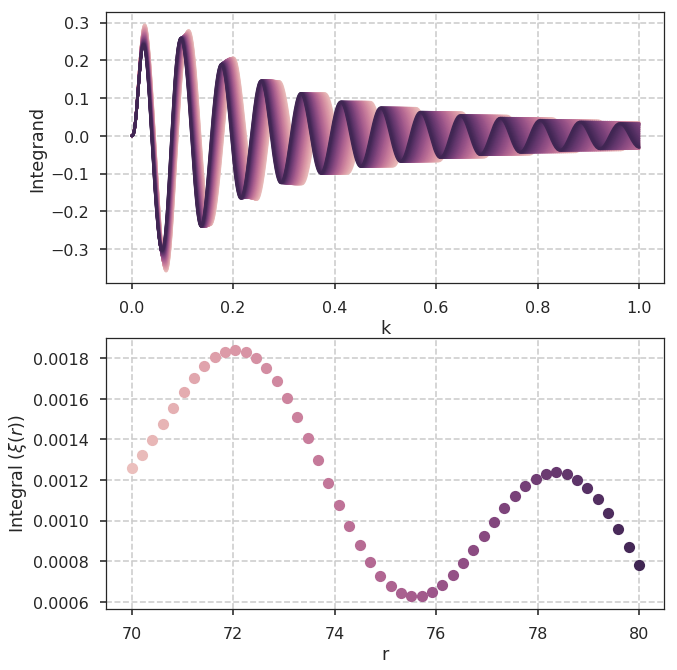

In [46]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(10,6))

n_curves = 50
colors = sns.cubehelix_palette(n_curves, hue=0.9, light=0.8, dark = 0.2)
rl = np.linspace(70, 80, n_curves)
for i, r in enumerate(rl):
    ax1.plot(kh, xi_integrand(r, kh, pk), color = colors[i])
    ax2.plot(r, xi(r, kh, pk), 'o', color = colors[i])
    
ax1.set_ylabel("Integrand")
ax2.set_ylabel(r"Integral ($\xi(r)$)")

ax1.set_xlabel("k")
ax2.set_xlabel("r")

plt.subplots_adjust(bottom=-0.5)

plt.show()

Looks the oscillatory behaviour isn't a numerical problem. I probably just need to take it out by expanding the correlation function ($\xi$) or fourier transforming only the appropriate mode from P(k)

### Let's look at Fourier transforms

### Trying on correlation function

r = np.linspace(70,120,500)
xi_r = [xi(i, kh, pk) for i in r]

x = r - 70
y = np.copy(xi_r)
####
N = len(x)
# sample spacing
T = (x.max()- x.min())/N
plt.plot(x,y)
plt.show()

yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.show()

def a_m(m, A_k, kmax=None):
    Ak = np.copy(A_k)
    if kmax is not None:
        Ak[kmax:] = 0
    k = np.arange(len(Ak))
    n = len(Ak)
    prod = np.dot(Ak,np.exp(2*np.pi*1j*m*k/n))
    return np.sum(prod)/n

def A_k(k, am):
    m = np.arange(len(am))
    n = len(am)
    prod = np.dot(am,np.exp(-2*np.pi*1j*m*k/n))
    return np.sum(prod)

a_m_list = [a_m(m,yf) for m in np.arange(500)]
A_k_list = [A_k(k,a_m_list) for k in np.arange(500)]
            
plt.plot(y,lw=10,alpha=0.6)
plt.plot(a_m_list)
plt.show()

plt.plot(yf,lw=10,alpha=0.6)
plt.plot(A_k_list)
plt.show()

# what happens when I cut off modes?
a_m_list = [a_m(m,yf, 500) for m in np.arange(500)]
plt.plot(x+70, y,lw=10,alpha=0.6)
plt.plot(x+70, a_m_list)
plt.show()

r = np.linspace(0,200,500)
xi_r = [xi(i, kh, pk) for i in r]

plt.plot(r,r**2*xi_r)
plt.xlim(0,200)
plt.show()